# Time Series Forecast

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from prophet import Prophet

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [57]:
energy_df = pd.read_csv('data/energy/AEP_hourly.csv', 
                        parse_dates=['Datetime'], 
                        index_col='Datetime')
energy_df = energy_df.sort_index()
energy_df.head()

,AEP_MW
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0


In [58]:
print("NULL Values:")
print(energy_df.isnull().sum())

NULL Values:
AEP_MW    0
dtype: int64


In [59]:
energy_df.describe()

,AEP_MW
count,121273.000000
mean,15499.513717
std,2591.399065
min,9581.000000
25%,13630.000000
50%,15310.000000
75%,17200.000000
max,25695.000000


In [60]:
print("Earliest Date:", energy_df.index.min())
print("Latest Date:", energy_df.index.max())

Earliest Date: 2004-10-01 01:00:00
Latest Date: 2018-08-03 00:00:00


In [61]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['day_of_year'] = df.index.dayofyear
    df['day_of_month'] = df.index.day
    df['week'] = df.index.isocalendar().week
    return df

In [62]:
df = create_features(energy_df)

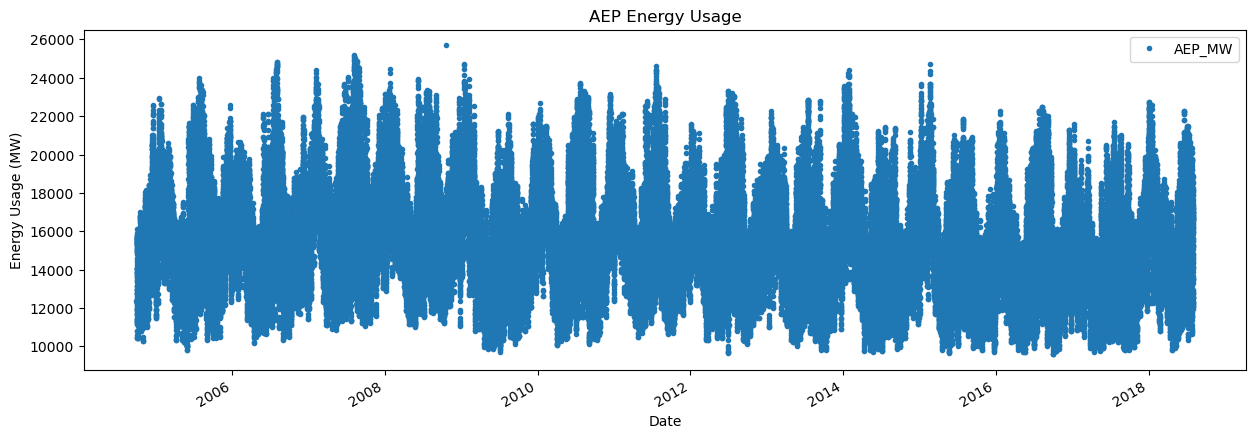

In [63]:
df.plot(y='AEP_MW',
        figsize=(15,5),
        title="AEP Energy Usage",
        style='.')
plt.ylabel('Energy Usage (MW)')
plt.xlabel('Date')
plt.show()

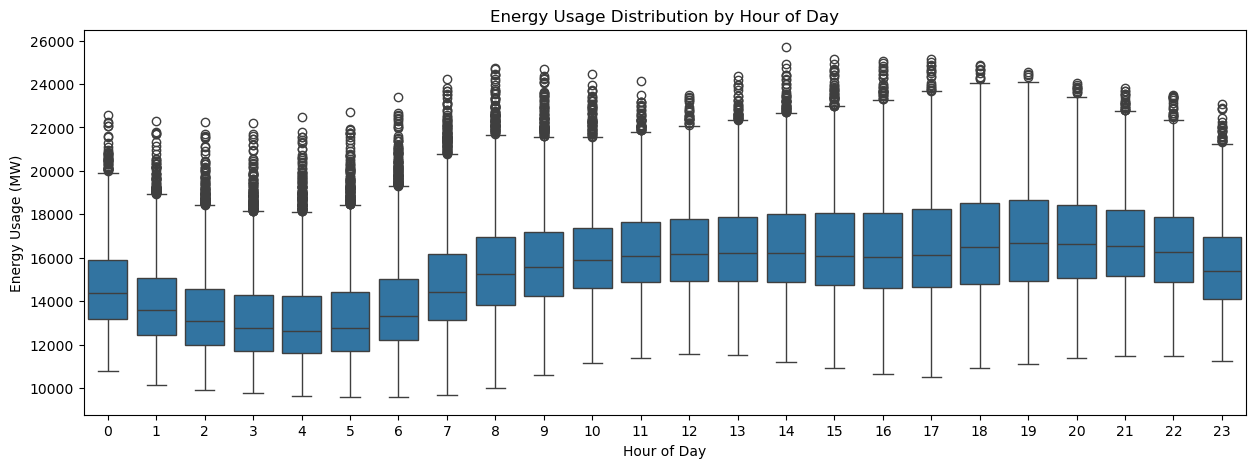

In [64]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x=df['hour'], y=df['AEP_MW'], ax=ax)
plt.title("Energy Usage Distribution by Hour of Day")
plt.ylabel('Energy Usage (MW)')
plt.xlabel('Hour of Day')
plt.show()

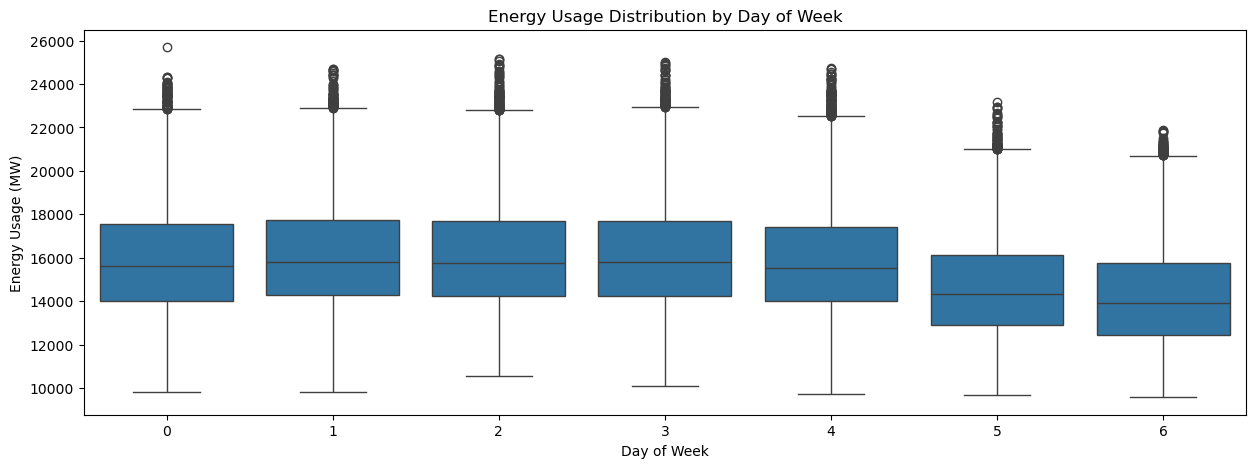

In [65]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x=df['day_of_week'], y=df['AEP_MW'], ax=ax)
plt.title("Energy Usage Distribution by Day of Week")
plt.ylabel('Energy Usage (MW)')
plt.xlabel('Day of Week')
plt.show()

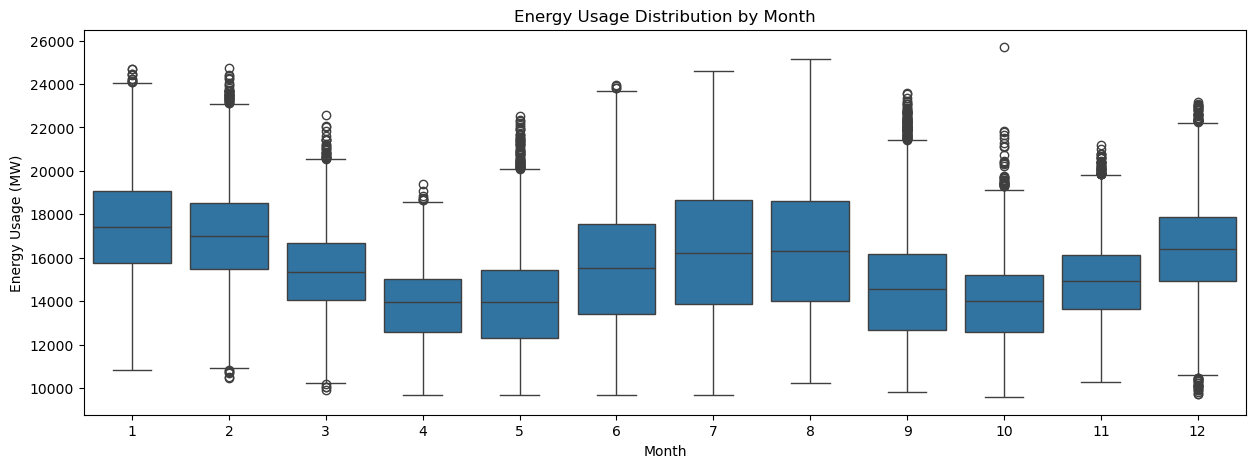

In [66]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x=df['month'], y=df['AEP_MW'], ax=ax)
plt.title("Energy Usage Distribution by Month")
plt.ylabel('Energy Usage (MW)')
plt.xlabel('Month')
plt.show()

In [67]:
# Split the data into training and testing sets (80% train:20% test)
train, test = train_test_split(df, test_size=0.2, shuffle=False)
print(f"Training set range: {train.index.min()} -> {train.index.max()}")
print(f"Testing set range: {test.index.min()} -> {test.index.max()}")

# Divide the train/test sets into features(X) and target(y)
X_train = train.drop('AEP_MW', axis=1)
y_train = train['AEP_MW']
X_test = test.drop('AEP_MW', axis=1)
y_test = test['AEP_MW']

Training set range: 2004-10-01 01:00:00 -> 2015-10-27 09:00:00
Testing set range: 2015-10-27 10:00:00 -> 2018-08-03 00:00:00


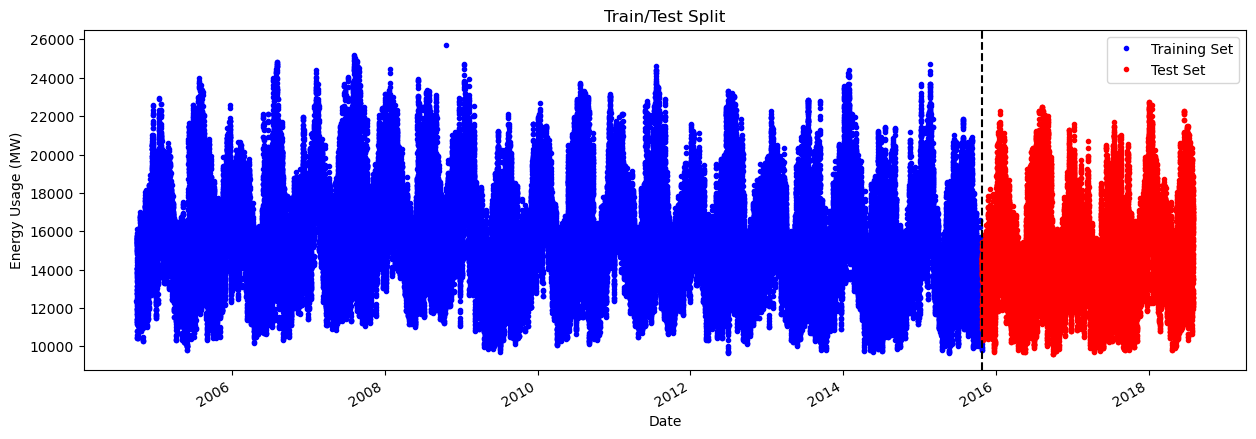

In [68]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(y='AEP_MW', ax=ax, label='Train Set', style='.', color='blue')
test.plot(y='AEP_MW', ax=ax, label='Test Set', style='.', color='red')
plt.title("Train/Test Split")
plt.ylabel('Energy Usage (MW)')
plt.xlabel('Date')
plt.legend(['Training Set', 'Test Set'])
plt.axvline(x=test.index.min(), color='black', linestyle='--' , label='Train/Test Split')
plt.show()

In [69]:
# XGBoost Model Training and Hyperparameter Tuning
xgb_model = xgb.XGBRegressor(
    objective = 'reg:squarederror',
    n_estimators = 1000, 
    early_stopping_rounds = None, 
    learning_rate = 0.01,
    max_depth = 5,
    random_state = 11)

xgb_param_grid = {
    'n_estimators': [100, 300, 500, 1000],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'min_child_weight': [1, 3, 5, 10]
}

tscv = TimeSeriesSplit(
    n_splits=5,
    gap=7
)

xgb_grid_search = GridSearchCV(
    estimator = xgb_model,
    param_grid = xgb_param_grid,
    scoring = 'neg_mean_squared_error',
    cv = tscv,
    n_jobs = -1,
    verbose = 2
)

xgb_grid_search.fit(X_train, y_train)

print(f"Best Parameters: {xgb_grid_search.best_params_}")
print(f"Best Score: {xgb_grid_search.best_score_}")

xgb_pred = xgb_grid_search.best_estimator_.predict(X_test)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 500}
Best Score: -2573531.265170532


In [72]:
# LightGBM Model Training and Hyperparameter Tuning
lgbm_model = lgb.LGBMRegressor(
    objective = 'regression',
    n_estimators = 500,
    learning_rate = 0.01,
    max_depth = 5,
    random_state = 11
)

lgbm_param_grid = {
    'n_estimators': [100, 300, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10]
}

lgbm_grid_search = GridSearchCV(
    estimator = lgbm_model,
    param_grid = lgbm_param_grid,
    scoring = 'neg_mean_squared_error',
    cv = tscv,
    n_jobs = -1,
    verbose = 2
)

lgbm_grid_search.fit(X_train, y_train)

print(f"Best Parameters: {lgbm_grid_search.best_params_}")
print(f"Best Score: {lgbm_grid_search.best_score_}")

lgbm_pred = lgbm_grid_search.best_estimator_.predict(X_test)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 97018, number of used features: 8
[LightGBM] [Info] Start training from score 15695.421509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

In [73]:
# Random Forest Model Training and Hyperparameter Tuning
rf_model = RandomForestRegressor(
    n_estimators = 100,
    max_depth = 5,
    min_samples_split = 5,
    n_jobs = -1,
    random_state = 11,
    verbose = False
)

rf_param_grid = {
    'n_estimators': [100, 300, 500, 1000],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 7, 10]
}

rf_grid_search = GridSearchCV(
    estimator = rf_model,
    param_grid = rf_param_grid,
    scoring = 'neg_mean_squared_error',
    cv = tscv,
    n_jobs = -1,
    verbose = 2
)

rf_grid_search.fit(X_train, y_train)

print(f"Best Parameters: {rf_grid_search.best_params_}")
print(f"Best Score: {rf_grid_search.best_score_}")

rf_pred = rf_grid_search.best_estimator_.predict(X_test)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Parameters: {'max_depth': 7, 'min_samples_split': 7, 'n_estimators': 100}
Best Score: -2876884.817081983


In [74]:
# Prophet Model Training
prophet_train = train.reset_index().rename(columns={'Datetime': 'ds', 'AEP_MW': 'y'})
prophet_test = test.reset_index().rename(columns={'Datetime': 'ds', 'AEP_MW': 'y'})
prophet_test = prophet_test[['ds']]

prophet_model = Prophet(
    yearly_seasonality = True,
    weekly_seasonality = True,
    daily_seasonality = False,
    seasonality_mode = 'multiplicative'
)

prophet_model.fit(prophet_train)
prophet_forecast = prophet_model.predict(prophet_test)
prophet_pred = prophet_forecast['yhat'].values

16:59:28 - cmdstanpy - INFO - Chain [1] start processing
17:00:28 - cmdstanpy - INFO - Chain [1] done processing


In [75]:
results = {}

results['XGBoost'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, xgb_pred)),
    'MAE': mean_absolute_error(y_test, xgb_pred),
    'R2': r2_score(y_test, xgb_pred),
    'predictions': xgb_pred
}
results['LightGBM'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, lgbm_pred)),
    'MAE': mean_absolute_error(y_test, lgbm_pred),
    'R2': r2_score(y_test, lgbm_pred),
    'predictions': lgbm_pred
}
results['Random Forest'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, rf_pred)),
    'MAE': mean_absolute_error(y_test, rf_pred),
    'R2': r2_score(y_test, rf_pred),
    'predictions': rf_pred
}
results['Prophet'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, prophet_pred)),
    'MAE': mean_absolute_error(y_test, prophet_pred),
    'R2': r2_score(y_test, prophet_pred),
    'predictions': prophet_pred
}

In [76]:
results

{'XGBoost': {'RMSE': np.float64(1699.4109612374493),
  'MAE': 1348.681807995452,
  'R2': 0.5166507556505515,
  'predictions': array([15196.8545, 15012.334 , 15027.398 , ..., 17775.041 , 16786.111 ,
         14380.109 ], dtype=float32)},
 'LightGBM': {'RMSE': np.float64(1700.5058179639036),
  'MAE': 1346.395360690576,
  'R2': 0.5160277531477029,
  'predictions': array([15197.60508155, 15020.42463721, 15031.34363335, ...,
         17809.36379653, 16711.50924026, 14230.04124771])},
 'Random Forest': {'RMSE': np.float64(1860.4796641011908),
  'MAE': 1494.4919849632925,
  'R2': 0.4206859408008258,
  'predictions': array([15477.37905123, 15477.37905123, 15477.37905123, ...,
         17619.50825753, 17619.50825753, 14485.38993664])},
 'Prophet': {'RMSE': np.float64(2169.636707638736),
  'MAE': 1713.0886378632258,
  'R2': 0.2121595886394384,
  'predictions': array([14516.36107792, 14507.39140797, 14497.85111765, ...,
         16221.98060229, 16212.02273005, 16201.46853456])}}

In [77]:
test['xgb_prediction'] = xgb_pred
test['lgbm_prediction'] = lgbm_pred
test['rf_prediction'] = rf_pred
test['prophet_prediction'] = prophet_pred
df = df.merge(test[['xgb_prediction', 'lgbm_prediction', 'rf_prediction', 'prophet_prediction']], how='left', left_index=True, right_index=True)

In [78]:
# ...existing code...
print(df.columns.tolist())
print(df.head())
# or search for similar names
print([c for c in df.columns if 'xgb' in c.lower()])
# ...existing code...

['AEP_MW', 'hour', 'day_of_week', 'month', 'quarter', 'year', 'day_of_year', 'day_of_month', 'week', 'xgb_prediction', 'lgbm_prediction', 'rf_prediction', 'prophet_prediction']
                      AEP_MW  hour  day_of_week  month  quarter  year  \
Datetime                                                                
2004-10-01 01:00:00  12379.0     1            4     10        4  2004   
2004-10-01 02:00:00  11935.0     2            4     10        4  2004   
2004-10-01 03:00:00  11692.0     3            4     10        4  2004   
2004-10-01 04:00:00  11597.0     4            4     10        4  2004   
2004-10-01 05:00:00  11681.0     5            4     10        4  2004   

                     day_of_year  day_of_month  week  xgb_prediction  \
Datetime                                                               
2004-10-01 01:00:00          275             1    40             NaN   
2004-10-01 02:00:00          275             1    40             NaN   
2004-10-01 03:00:00    

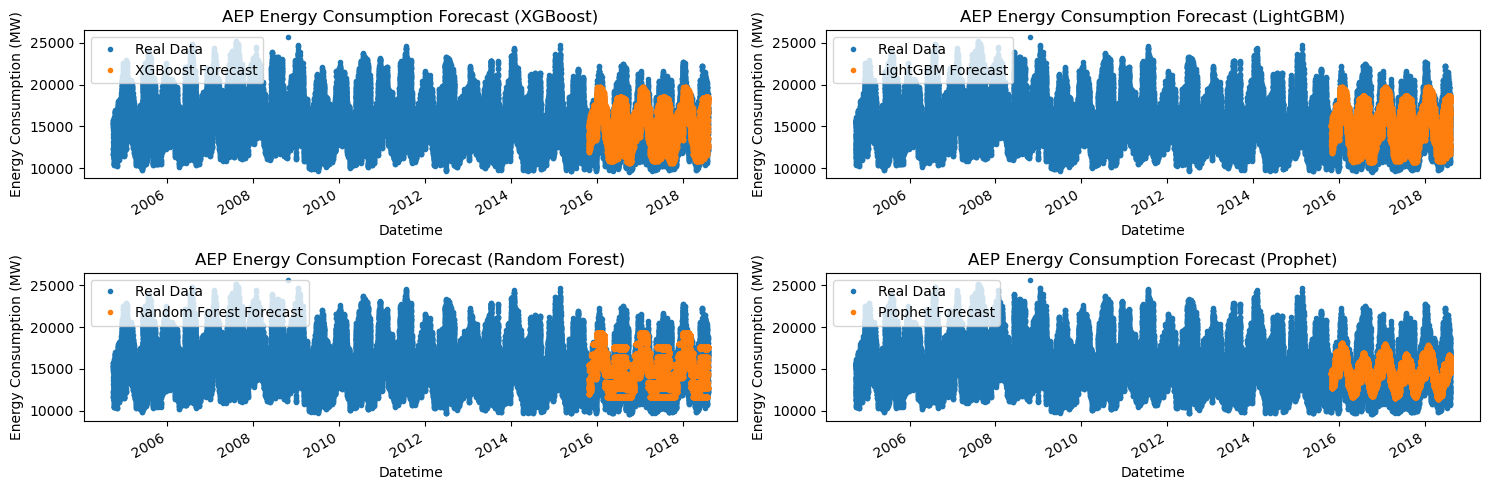

In [83]:
fig, ax = plt.subplots(2, 2, figsize=(15,5))
ax00 = ax[0,0]
df[['AEP_MW']].plot(figsize=(15,5), style='.', ax=ax[0,0])
df['xgb_prediction'].plot(ax=ax[0,0], style='.')
ax00.set_title('AEP Energy Consumption Forecast (XGBoost)')
ax00.set_ylabel('Energy Consumption (MW)')
ax00.legend(['Real Data','XGBoost Forecast'], loc = 'upper left')

ax01 = ax[0,1]
df[['AEP_MW']].plot(figsize=(15,5), style='.', ax=ax[0,1])
df['lgbm_prediction'].plot(ax=ax[0,1], style='.')
ax01.set_title('AEP Energy Consumption Forecast (LightGBM)')
ax01.set_ylabel('Energy Consumption (MW)')
ax01.legend(['Real Data','LightGBM Forecast'], loc = 'upper left')

ax10 = ax[1,0]
df[['AEP_MW']].plot(figsize=(15,5), style='.', ax=ax[1,0])
df['rf_prediction'].plot(ax=ax[1,0], style='.')
ax10.set_title('AEP Energy Consumption Forecast (Random Forest)')
ax10.set_ylabel('Energy Consumption (MW)')
ax10.legend(['Real Data','Random Forest Forecast'], loc = 'upper left')

ax11 = ax[1,1]
df[['AEP_MW']].plot(figsize=(15,5), style='.', ax=ax[1,1])
df['prophet_prediction'].plot(ax=ax[1,1], style='.')
ax11.set_title('AEP Energy Consumption Forecast (Prophet)')
ax11.set_ylabel('Energy Consumption (MW)')
ax11.legend(['Real Data','Prophet Forecast'], loc = 'upper left')

plt.tight_layout()
plt.show()